In [105]:
import cv2
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [106]:
def read_images(path):
    images=[]
    labels=[]
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    for image_path in image_paths:
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, dtype=np.float64)
        nbr = int(os.path.split(image_path)[1].split(".")[0].replace("subject", ""))
        images.append(image)
        labels.append(nbr)
    return images,labels


In [108]:
img_dir='training_set'
path=os.path.join(os.getcwd(),img_dir)
image,labels=read_images(path)

In [109]:
img_height=200
img_width=200
n_images=len(image)

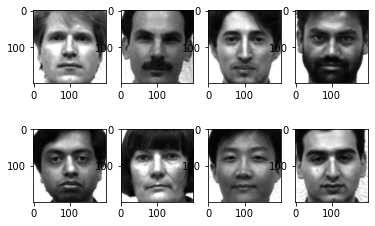

In [110]:
################## Creating flattened image_vector ####################################
image_vectors=np.zeros([n_images,img_height*img_width],dtype=np.float64)  # 166x (243*320)
for i in range(n_images):
    image_vectors[i,:]=np.array(image[i],dtype=np.float64).flatten()
    plt.subplot(2,4,i+1)
    plt.imshow(image[i],cmap="gray")
plt.show()

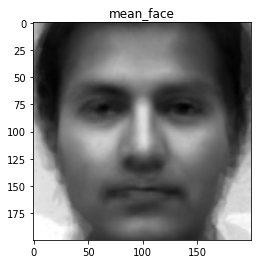

In [111]:

######################## Creating mean face of training set ###############################
mean_face=np.zeros((1,img_height*img_width),dtype=np.float64)           # 1 x (243*320)
for i in range(n_images):
    mean_face=image_vectors[i]+mean_face
mean_face=np.divide(mean_face,n_images)
plt.imshow(mean_face.reshape(img_height,img_width), cmap="gray")
plt.title('mean_face')
plt.show()


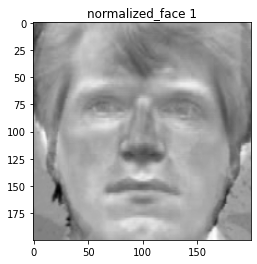

[-14. -22. -26. -33. -42. -44. -40. -36. -32. -24. -16.  -9.   5.  21.
  35.  46.  54.  58.  64.  63.  63.  66.  72.  83.  82.  79.  74.  68.
  66.  65.]


In [112]:

################# Normalizing image_vector (zeroing the data) ############################
normalized_image_vectors=np.array((image_vectors-mean_face).round(),dtype=np.float64)                 # 166x (243*320)
plt.imshow(normalized_image_vectors[0].reshape(img_height,img_width), cmap="gray")
plt.title('normalized_face 1')
plt.show()
print(normalized_image_vectors[0][:30])

In [16]:

########################### Finding covariance matrix of MxM dimension ####################
### As (height*width) is large, covariance of that matrix would be huge. (Complete the explanation) ###
covariance_initial=np.cov(normalized_image_vectors)                    # 166x 166
covariance_initial=np.divide(covariance_initial,8.0)
eigenvalues_initial, eigenvectors_initial = np.linalg.eig(covariance_initial)
print(eigenvalues_initial)

[1.00286405e+03 5.89507779e-02 3.05353262e+02 2.49255980e+02
 1.76208720e+02 9.14159999e+01 1.22796492e+02 1.28111242e+02]


In [17]:
print(eigenvectors_initial)

[[-0.16938857  0.3535056  -0.16138007 -0.40132993  0.37069779 -0.09928912
  -0.7143947   0.03996356]
 [ 0.20122818  0.35357361 -0.29906515  0.2064198   0.39700279 -0.02973339
   0.25016783 -0.69380443]
 [ 0.12232356  0.35361462 -0.06102694 -0.56344779  0.15037686  0.36365451
   0.52242043  0.33318919]
 [ 0.29358322  0.35363351  0.34285167  0.56494353  0.23311723  0.38459823
  -0.20351663  0.32918888]
 [ 0.18672877  0.35365597  0.413934   -0.25246936 -0.59700381  0.17165161
  -0.17878983 -0.43258995]
 [-0.85862101  0.35361318 -0.02537194  0.23992    -0.14762241  0.18965893
   0.14505535 -0.02680277]
 [-0.01529204  0.35333263  0.42850658  0.01027784  0.0859228  -0.77541934
   0.23730864  0.16194261]
 [ 0.23943484  0.35349789 -0.63846846  0.19565923 -0.49236819 -0.20588166
  -0.05823994  0.28910225]]


In [113]:

##### Arranging in decreasing eigen value order, and then selecting principal components ####
couple=[(eigenvalues_initial[i],eigenvectors_initial[:,i]) for i in range(len(eigenvalues_initial))]
couple.sort(reverse=True)
eigenvalues_initial_ordered=[couple[i][0] for i in range(len(couple))]
print(eigenvalues_initial_ordered)
eigenvectors_initial_ordered=[couple[i][1] for i in range(len(couple))]
print(eigenvectors_initial_ordered)

[1002.8640519763613, 305.353262134806, 249.25598021522168, 176.20871962185404, 128.11124156808347, 122.79649192906179, 91.41599990035084, 0.05895077788717251]
[array([-0.16938857,  0.20122818,  0.12232356,  0.29358322,  0.18672877,
       -0.85862101, -0.01529204,  0.23943484]), array([-0.16138007, -0.29906515, -0.06102694,  0.34285167,  0.413934  ,
       -0.02537194,  0.42850658, -0.63846846]), array([-0.40132993,  0.2064198 , -0.56344779,  0.56494353, -0.25246936,
        0.23992   ,  0.01027784,  0.19565923]), array([ 0.37069779,  0.39700279,  0.15037686,  0.23311723, -0.59700381,
       -0.14762241,  0.0859228 , -0.49236819]), array([ 0.03996356, -0.69380443,  0.33318919,  0.32918888, -0.43258995,
       -0.02680277,  0.16194261,  0.28910225]), array([-0.7143947 ,  0.25016783,  0.52242043, -0.20351663, -0.17878983,
        0.14505535,  0.23730864, -0.05823994]), array([-0.09928912, -0.02973339,  0.36365451,  0.38459823,  0.17165161,
        0.18965893, -0.77541934, -0.20588166]), 

In [114]:
principal_eigenvalues_initial=eigenvalues_initial_ordered[:]
principal_eigenvectors_initial=eigenvectors_initial_ordered[:]
principal_eigenvectors_initial=(np.array(principal_eigenvectors_initial))
print(principal_eigenvalues_initial)

[1002.8640519763613, 305.353262134806, 249.25598021522168, 176.20871962185404, 128.11124156808347, 122.79649192906179, 91.41599990035084, 0.05895077788717251]


In [20]:
principal_eigenvectors_initial

array([[-0.16938857,  0.20122818,  0.12232356,  0.29358322,  0.18672877,
        -0.85862101, -0.01529204,  0.23943484],
       [-0.16138007, -0.29906515, -0.06102694,  0.34285167,  0.413934  ,
        -0.02537194,  0.42850658, -0.63846846],
       [-0.40132993,  0.2064198 , -0.56344779,  0.56494353, -0.25246936,
         0.23992   ,  0.01027784,  0.19565923],
       [ 0.37069779,  0.39700279,  0.15037686,  0.23311723, -0.59700381,
        -0.14762241,  0.0859228 , -0.49236819],
       [ 0.03996356, -0.69380443,  0.33318919,  0.32918888, -0.43258995,
        -0.02680277,  0.16194261,  0.28910225],
       [-0.7143947 ,  0.25016783,  0.52242043, -0.20351663, -0.17878983,
         0.14505535,  0.23730864, -0.05823994],
       [-0.09928912, -0.02973339,  0.36365451,  0.38459823,  0.17165161,
         0.18965893, -0.77541934, -0.20588166],
       [ 0.3535056 ,  0.35357361,  0.35361462,  0.35363351,  0.35365597,
         0.35361318,  0.35333263,  0.35349789]])

In [21]:

##### Finding actual eigenvector by premultiplying with previous eigen vector. Refer Turk, Pentland paper for info #####
eigenvectors_actual=np.dot(normalized_image_vectors.transpose(),principal_eigenvectors_initial)
print("Shape of actual eigen vector matrix:",eigenvectors_actual.shape)
print(eigenvectors_actual[:30])


Shape of actual eigen vector matrix: (40000, 8)
[[ -37.11614598 -115.72585567  103.38626559  -72.57207253  -66.91209507
   -72.44542594  -51.60798478 -162.2083232 ]
 [ -39.03910079 -117.38616171  100.19182291  -71.71704829  -70.99838197
   -64.94916704  -52.00266323 -164.95835756]
 [ -40.82351009 -119.30124639   99.22987878  -71.49512271  -72.03268211
   -60.95829419  -52.30785634 -165.99939598]
 [ -39.21285203 -122.41667507  103.85434638  -73.27595176  -70.7235227
   -54.134086    -51.16317139 -168.13219054]
 [ -65.41665619 -147.88725815  108.53713545  -71.02268983  -38.91456387
   -29.9393181   -50.61614685 -146.01639414]
 [ -94.25229304 -171.59085948  110.95139313  -67.3702929    -4.0193105
   -10.17520775  -51.13096609 -116.93181259]
 [-120.64106205 -189.11192661  109.96157735  -64.22295322   23.35327156
     1.47867528  -52.7107946   -87.17962783]
 [-129.55815867 -193.07383133  114.27511152  -65.69469088   26.02416582
     2.58978017  -55.83104494  -72.14926131]
 [-131.20506998 -1

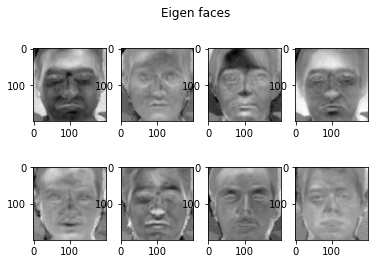

In [22]:
#### Creating Eigen faces by simply reshaping ########

for i in range(len(principal_eigenvalues_initial)):
    eigenface_vector=np.array([eigenvectors_actual[:,i]])
    eigenface=eigenface_vector.reshape(img_height,img_width)
    plt.subplot(2,4,i+1)
    plt.imshow(eigenface,cmap="gray")
plt.suptitle("Eigen faces")
plt.show()

In [34]:
#### Finding weights which give the linear combination coefficients for describing training faces using eigen faces #####
weights = np.dot(normalized_image_vectors , eigenvectors_actual)
print(eigenvectors_actual.shape)


(40000, 8)


In [116]:
#### Reconstructing trial for first training image #####
plt.figure(2)
#for i in range(n_images):
wts=np.array(weights.transpose())
wts=np.divide(wts,wts.max())
print("shape of eigenvectors_actual is",eigenvectors_actual.shape)
print("shape of wts is ",wts.shape)
reconstructed_face=np.dot(eigenvectors_actual,wts)
print("wights are:",wts)
#print('reconstructed vector 0:')
print(reconstructed_face.shape)


shape of eigenvectors_actual is (40000, 8)
shape of wts is  (8, 8)
wights are: [[-0.31992755  0.3434596   0.06938188  0.71746971  0.34627822 -1.75835123
  -0.0554701   0.65700765]
 [ 0.30260707 -0.16334663 -0.0038406  -0.10480835 -0.51533621  0.42848468
  -0.12124117  0.17751835]
 [-0.11875733 -0.23286757 -0.47116899 -0.07412589 -0.01849148  1.
   0.12532028 -0.20961389]
 [ 0.002633    0.20574615  0.32587782  0.18759203  0.19065487 -1.22439222
  -0.03387697  0.34608879]
 [ 0.43005219  0.20870554  0.05461943 -0.4161681  -0.35929463 -0.19358951
  -0.18847784  0.46408994]
 [-0.6317242   0.07732773 -0.00876392  0.15721733  0.12422306  0.07254712
   0.10879788  0.10048147]
 [ 0.00492307  0.23120738 -0.04599067 -0.06759788 -0.09017268 -0.01827673
  -0.37255969  0.35838205]
 [ 0.5309078  -0.34851666  0.24688108 -0.55083215  0.01987593 -0.02241242
  -0.19207895  0.31596474]]
(40000, 8)


<Figure size 432x288 with 0 Axes>

In [117]:
print(mean_face[:30])

[[190.25  189.5   188.25  ... 221.    223.625 225.375]]


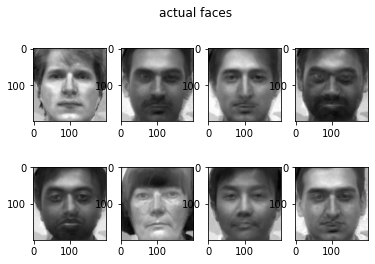

In [118]:
for i in range(n_images):
    plt.subplot(2,4,i+1)
    total_face=np.add(reconstructed_face[:,i],1*mean_face)
    plt.imshow(total_face.reshape(img_height,img_width),cmap="gray")
    
plt.suptitle('actual faces')
plt.show()

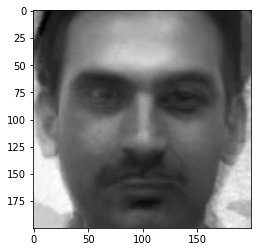

In [133]:
one_face=reconstructed_face[:,1]+1*mean_face
plt.imshow(one_face.reshape(200,200),cmap="gray")
plt.show()

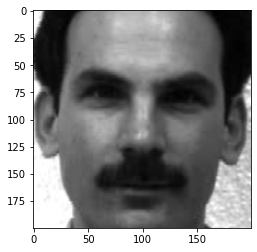

In [130]:
plt.imshow(image_vectors[1].reshape(200,200),cmap="gray")
plt.show()

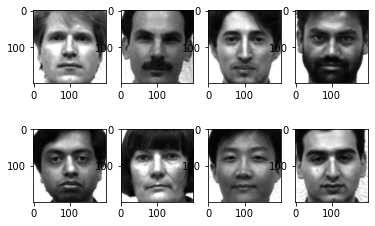

In [119]:
image_vectors=np.zeros([n_images,img_height*img_width],dtype=np.float64)  # 166x (243*320)
for i in range(n_images):
    image_vectors[i,:]=np.array(image[i],dtype=np.float64).flatten()
    plt.subplot(2,4,i+1)
    plt.imshow(image[i],cmap="gray")
plt.show()

D:\My Github\OpenCV_basics\Face detection and recognition


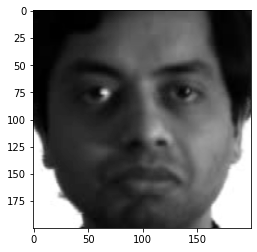

In [91]:
img_dir='newfaces'
path=os.path.join(os.path.join(os.getcwd(),img_dir),'subjecttest.pgm')
print(os.getcwd())
test_img = Image.open(path).convert('L')
test_image = np.array(test_img, dtype=np.float64)
plt.imshow(test_image,cmap="gray")
plt.show()

In [92]:
test_image_vector=test_image.flatten()


In [93]:
test_image_vector.shape

(40000,)

In [94]:
normalized_test=test_image_vector-mean_face

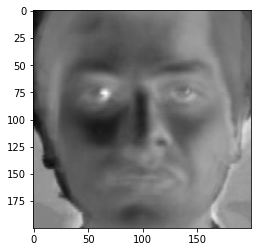

In [95]:
plt.imshow(normalized_test.reshape(img_height,img_width),cmap="gray")
plt.show()

In [96]:
w_unknown=np.dot(normalized_test,eigenvectors_actual)

In [97]:
w_unknown.shape

(1, 8)

In [98]:
weights

array([[-3.80399125e+07,  3.59804792e+07, -1.41204415e+07,
         3.13068149e+05,  5.11339137e+07, -7.51130475e+07,
         5.85361592e+05,  6.31258117e+07],
       [ 4.08379115e+07, -1.94221836e+07, -2.76883375e+07,
         2.44635554e+07,  2.48154328e+07,  9.19439446e+06,
         2.74909386e+07, -4.14392052e+07],
       [ 8.24961963e+06, -4.56653567e+05, -5.60227682e+07,
         3.87474088e+07,  6.49434023e+06, -1.04204406e+06,
        -5.46836610e+06,  2.93545664e+07],
       [ 8.53083296e+07, -1.24618857e+07, -8.81369026e+06,
         2.23050015e+07, -4.94830729e+07,  1.86933995e+07,
        -8.03749972e+06, -6.54948502e+07],
       [ 4.11730500e+07, -6.12743240e+07, -2.19866738e+06,
         2.26691776e+07, -4.27207235e+07,  1.47703259e+07,
        -1.07216799e+07,  2.36328081e+06],
       [-2.09070857e+08,  5.09475335e+07,  1.18901647e+08,
        -1.45582250e+08, -2.30181111e+07,  8.62597249e+06,
        -2.17313356e+06, -2.66487386e+06],
       [-6.59548578e+06, -1.441577

In [99]:
w_unknown

array([[ 20422394.69935637, -35967878.0204958 ,  18606576.06290223,
         -3511265.44055226, -35474589.29593603,  35900645.47213075,
        -10618194.73007436, -41579954.51918238]])

In [100]:
sse=np.zeros(len(weights))
for i in range(len(weights)):
    sse[i]=((weights[i]-w_unknown).sum())**2

print(sse)

[5.78930744e+15 8.18568440e+15 5.19529126e+15 1.17224049e+15
 2.65126492e+14 2.30468249e+16 1.19209829e+15 9.92157294e+16]


In [101]:
print(sse.min())

265126491710328.38


In [70]:
a=np.array([1,2,3,4])

In [74]:
sum=a.sum()


In [75]:
print(sum)

10
